# Introduction to ECoG and EEG

## Overview
Our first class is going to cover the background of Electroencephalography (EEG) and Electrocorticography (ECoG). These are the kinds of data we'll use in the first half of this class. Below is a list of topics that we'll focus on.

## Goals for today
* Load some raw data into python
* Simple visualizations to understand the kind of data we have
* Learn some things about the data by scanning the raw values
* Introduction to the MNE library for electrophysiology

---

# Background
See the Powerpoint for this week for a quick intro to ECoG and EEG. It has some background on the history of these methods, what kinds of signals they measure, and what kinds of things we'll try to do with them.


# Visualizing electrophysiology data in python

## What is a timeseries?
In neuroscience, the most common form of data is called a *timeseries*. This essentially means that we have a sensor that collects information about some signal in the brain as it changes across time.

A timeseries can be anything from stock market fluctuations, to the changes in score during a basketball game, to electrical fluctuations in the brain.

In this course, we discuss two types of timeseries from the human brain:

1. Voltage on the brain surface, recorded from electrodes.
2. A measure of blood flow in the cortex of the brain, recorded with an fMRI machine.



In [44]:
import os
import mne
from matplotlib import pyplot as plt
import numpy as np
import os.path as op
from glob import glob
from warnings import simplefilter
simplefilter('ignore')
import neurods
import sys

In [45]:
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.cmap'] = 'viridis'

In [46]:
%matplotlib inline

## A sample timeseries
First, let's load a sample EEG timeseries so we can see what it looks like.

In [49]:
path_data = glob(neurods.io.data_list['eeg'] + '/subject8/session1/*-raw.fif')[0]
path_events = glob(neurods.io.data_list['eeg'] + '/subject8/session1/*-eve*')[0]
raw = mne.io.Raw(path_data, preload=True)

# Drop mastoid channels
chs_drop = ['MA1', 'MA2']
raw.drop_channels(chs_drop)

Opening raw data file /data/shared/cogneuro88/eeg/subject8/session1/eeg-raw.fif...
Isotrak not found
    Range : 0 ... 125336 =      0.000 ...    61.199 secs
Ready.
add_eeg_ref defaults to True in 0.13, will default to False in 0.14, and will be removed in 0.15. We recommend to use add_eeg_ref=False and set_eeg_reference() instead.
Adding average EEG reference projection.
1 projection items deactivated
Reading 0 ... 125336  =      0.000 ...    61.199 secs...


<Raw  |  eeg-raw.fif, n_channels x n_times : 32 x 125337 (61.2 sec), ~30.7 MB, data loaded>

In [52]:
# The eeg data in this object is accessible at `raw._data`:
raw._data.shape

(32, 125337)

In [53]:
raw._data

array([[-17640.65625, -17641.21875, -17642.625  , ...,      0.     ,
             0.     ,      0.     ],
       [-14235.625  , -14233.875  , -14236.09375, ...,      0.     ,
             0.     ,      0.     ],
       [-15628.15625, -15625.09375, -15629.875  , ...,      0.     ,
             0.     ,      0.     ],
       ..., 
       [-12308.3125 , -12306.90625, -12305.6875 , ...,      0.     ,
             0.     ,      0.     ],
       [ -6313.     ,  -6311.875  ,  -6311.25   , ...,      0.     ,
             0.     ,      0.     ],
       [  1204.625  ,   1203.5    ,   1203.     , ...,      0.     ,
             0.     ,      0.     ]])

## Breakout session
> What does this data look like? explore it in as many ways as you can think of!
> Hint: Try to plot individual EEG channels, and also multiple channels!

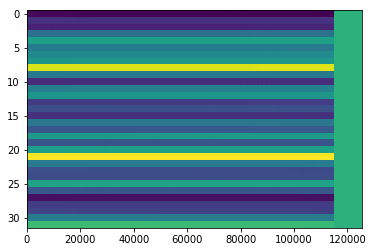

In [55]:
_ = plt.imshow(raw._data)

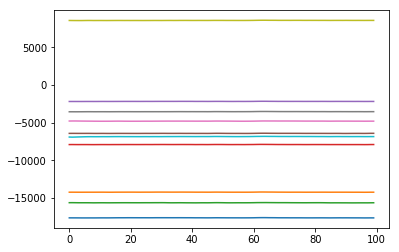

In [68]:
_ = plt.plot(raw._data[:10, :100].T)

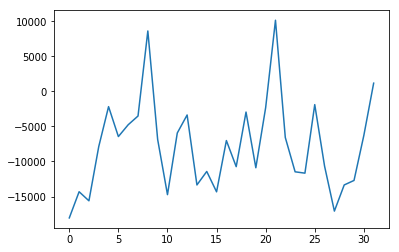

In [56]:
_ = plt.plot(raw._data[:,23333])


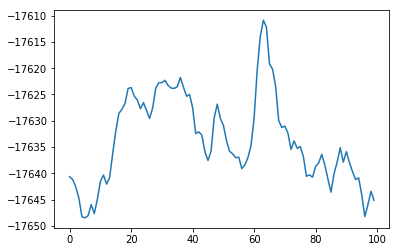

In [57]:
_ = plt.plot(raw._data[0, :100])

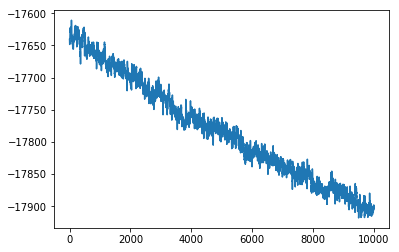

In [58]:
_ = plt.plot(raw._data[0, :10000])

(array([ 114688.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   10649.]),
 array([-18327.59375 , -16494.834375, -14662.075   , -12829.315625,
        -10996.55625 ,  -9163.796875,  -7331.0375  ,  -5498.278125,
         -3665.51875 ,  -1832.759375,      0.      ]),
 <a list of 10 Patch objects>)

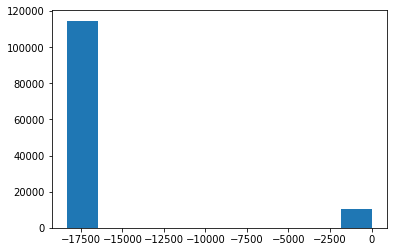

In [59]:
plt.hist(raw._data[0])

(array([ 1523.,  2597.,  3587.,  3373.,  1988.,  1620.,  1941.,  1210.,
         1484.,   677.]),
 array([-18059.40625 , -18014.553125, -17969.7     , -17924.846875,
        -17879.99375 , -17835.140625, -17790.2875  , -17745.434375,
        -17700.58125 , -17655.728125, -17610.875   ]),
 <a list of 10 Patch objects>)

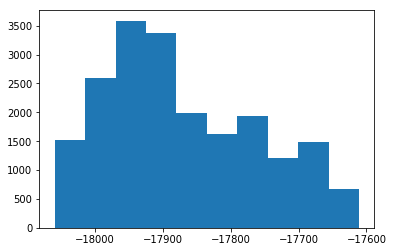

In [63]:
plt.hist(raw._data[0][:20000])

What did you notice about the activity in these channels? Is it similar to what we saw in fMRI?

How could you manipulate the data (add something, multiply by something, subtract something) to make a more sensible / informative plot?

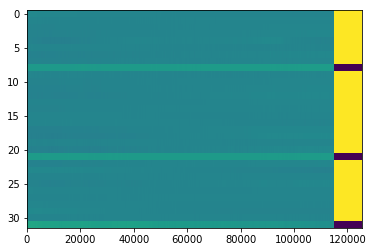

In [64]:
### STUDENT ANSWER
from scipy.stats import zscore
plt.imshow(zscore(raw._data, axis=1))

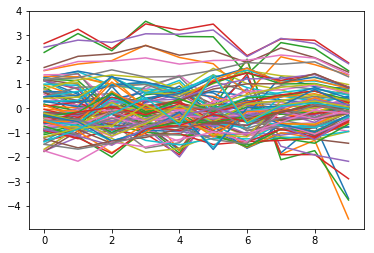

In [73]:
_ = plt.plot(zscore(raw._data[:10, :100], axis=1))

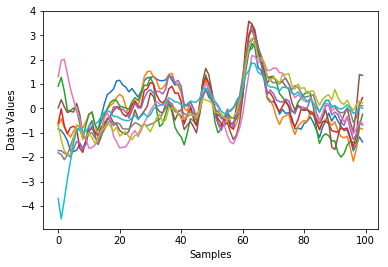

In [77]:
plt.plot(zscore(raw._data[:10, :100].T))
plt.xlabel('Samples')
plt.ylabel('Data Values')

Remember that it's always important to take a look at the raw data first, and to make sure you've standardized / cleaned up the data if there are any obvious problems at the very beginning.

## Using MNE to represent our data
Because a timeseries has a specific structure (signals varying over time), there are a number of packages designed to handle this particular kind of data. One of the best python packages for neuroscience is called `MNE-python`. Check out their website here: http://martinos.org/mne/stable/index.html

MNE has code that can handle datasets like the one we've used above. The main class we'll focus on are `Raw` objects. These are similar to the `.nii` files that we're been working with in fMRI, but they represent EEG data instead.

`Raw` data objects are simple a way of keeping the data (which is of shape `n_channels x n_times`) along with some metadata that gives extra information about our data. Note that the convention here is different from fMRI data: time is the LAST dimension instead of the FIRST! (Confusing ,yes; so it goes.)

For example, any object that represents data in `MNE-python` will have an `info` attribute. This is a collection of information about the data at hand. It includes information like:

* `info['sfreq']` - The sampling frequency of the data
* `info['ch_names']` - The names of channels in the data
* `info['bads']` - A list of "bad" channels
* `info['chs']` - A more complex collection of channel information, such as xyz location.

There are many other pieces of information related to things that are important in EEG analysis, most of which we won't go into.

In [76]:
# Here's a list of all the things in an Info object
raw.info['sfreq']

2048.0

We can also always access the numpy array of data by accessing the `._data` attribute. **Note** This only works if the data has been *preloaded* (MNE sometimes holds off on loading the data from disk so that it doesn't use up memory, just like we saw with the nibabel package for fMRI data).

In [ ]:
# Make sure the data is loaded
raw.load_data()

In [ ]:
print(raw._data.shape)
print(raw._data)

### Sampling Frequency

The time values for this signal tell us how much time passes between observations of the signal. It's a crucial piece of information in order to do many analyses in neuroscience.

The **sampling frequency** (or sampling rate) is the number of samples we record *per second*. We can calculate this by this equation:

$$sampling\_frequency = samples\_per\_second = \frac{n\_samples}{1\_second} = \frac{1\_sample}{seconds\_between\_samples} = \frac{1}{signal\_period}$$

We know the sampling frequency of this dataset (it's stored in raw.info) How could we use it to calculate the time dimension?

In [82]:
raw.info['sfreq']

2048.0

In [90]:
plt.close()

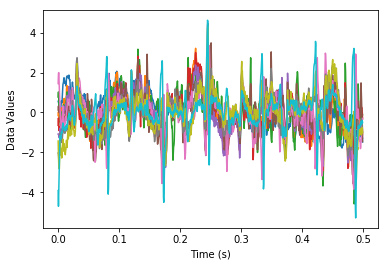

In [85]:
### STUDENT ANSWER
n_times = raw._data.shape[1]
indices = np.arange(n_times)
seconds = indices / raw.info['sfreq']

plt.plot(seconds[:1024], zscore(raw._data[:10, :1024].T))
plt.xlabel('Time (s)')
plt.ylabel('Data Values')

## Plotting raw data with MNE
MNE has a lot of plotting functionality, which is one of the most important things to do in data analysis. Below we'll explore the basic ways in which we can visualize our data.

In [86]:
# To use this, we'll need to activate "interactive" mode
# This lets us keep plots interactive in the notebook
%matplotlib notebook

First, we'll plot the raw data. This will give us an output of traces, one for each channel. The x-axis is time (in seconds). What we are looking at is the electrical activity (voltage) recorded at the scalp, and generated by neural activity.

<IPython.core.display.Javascript object>


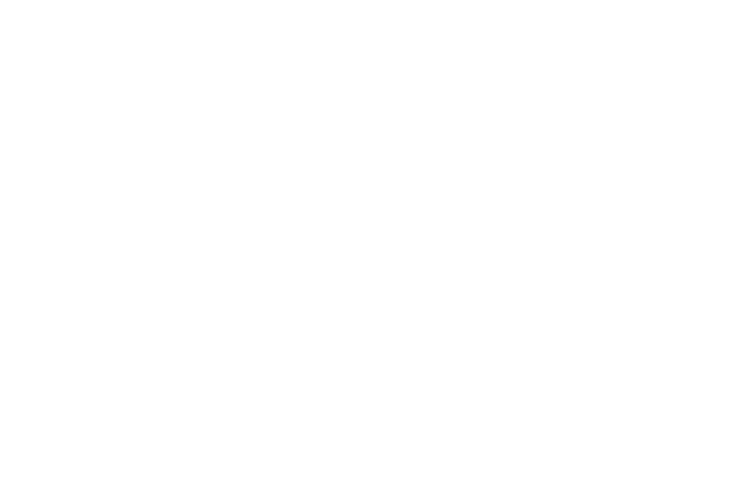

<IPython.core.display.Javascript object>


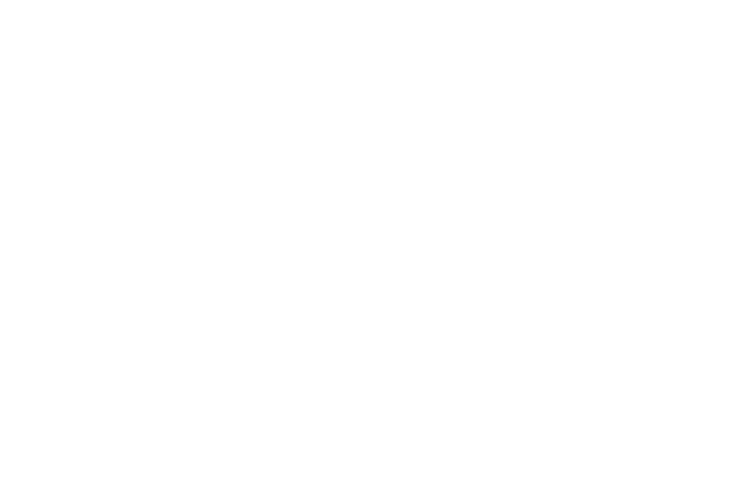

In [92]:
# Putting `_` before the equals sign tells Python to throw away the output
# Otherwise, it will make 2 plots.
raw.crop(0, 40)
raw._data = raw._data - raw._data.mean(-1)[:, np.newaxis]
fig = raw.plot(scalings='auto')

<IPython.core.display.Javascript object>


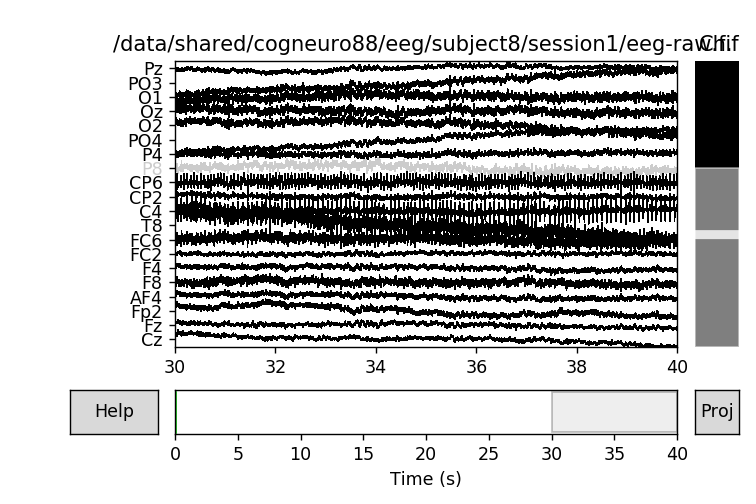

In [94]:
fig

### Breakout session
Scan through this dataset using the `raw.plot` function.

* Take note of the shapes and sizes of the signal in each electrode.
* In addition, see if you notice any points in time where the nature of the signal changes.

## Smoothing our data
You may notice that the raw signal seems to be quite noisy. Some electrodes have activity that is jumping around quite a lot, there are also some electrodes that seem to "drift" over time, meaning their average value slowly gets larger or smaller.

Let's see an example of one plot of data below...

In [95]:
%matplotlib inline

In [101]:
raw_filt = mne.io.Raw(path_data, preload=True)

Opening raw data file /data/shared/cogneuro88/eeg/subject8/session1/eeg-raw.fif...
Isotrak not found
    Range : 0 ... 125336 =      0.000 ...    61.199 secs
Ready.
add_eeg_ref defaults to True in 0.13, will default to False in 0.14, and will be removed in 0.15. We recommend to use add_eeg_ref=False and set_eeg_reference() instead.
Adding average EEG reference projection.
1 projection items deactivated
Reading 0 ... 125336  =      0.000 ...    61.199 secs...


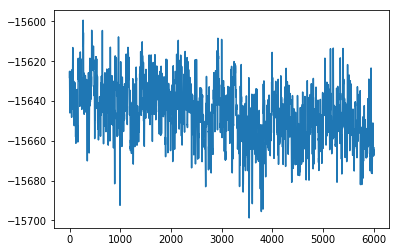

In [102]:
# First, we'll plot a single channel
fig, ax = plt.subplots()
ch_plt = 2
ax.plot(raw_filt._data[ch_plt, :6000].T)

Notice how there are different kinds of activity here. There are some more slow-changing parts (e.g. the bumps that occur over 100 samples. There are also some really "jittery" parts of the signal that quickly bounce up and down.

Neuroscientists often assume that the jittery parts of our data correspond to noise in the system. This kind of activity has a "high frequency", meaning that it changes very quickly.

To emphasize either the slow-moving or fast-moving parts of our signal, we can *filter* it. This means removing the parts of the signal that we aren't interested in. For example, if we want to remove the fast-changing jittery stuff, we can filter out the higher frequency activity in the signal. This is called a *low pass filter*.

Low-pass filtering at 20 Hz
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


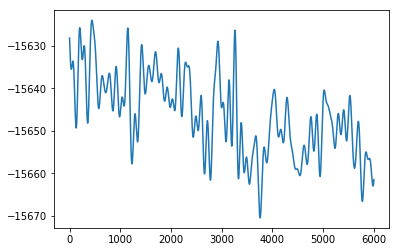

In [104]:
fmin, fmax = None, 20
raw_filt.filter(fmin, fmax)
fig, ax = plt.subplots()
ax.plot(raw_filt._data[ch_plt, :6000].T)

### Breakout session
We have mentioned "drift" a few times thus far. This occurs when the signal changes very slowly over time. One way to think of this kind of activity is that it is a very low-frequency component of the signal (AKA, it changes slowly). See if you can use the `.filter` method on our raw object to remove this drift in the signal.

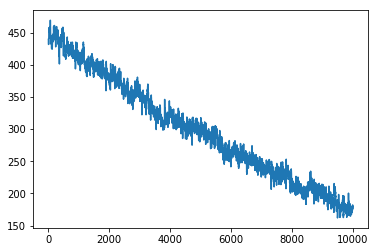

In [105]:
### STUDENT ANSWER
_ = plt.plot(raw._data[0, :10000])

High-pass filtering at 2 Hz
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


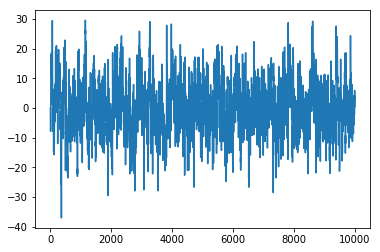

In [106]:
fmin, fmax = 2, None
plt.plot(raw.copy().filter(fmin, fmax)._data[0, :10000])

Below we can see how several kinds of filters have different effects on our data. We can remove the high-frequency parts of the signal as we did above (called low-pass filtering or smoothing), we can also remove the low-frequency parts of the signal as we did in the breakout session (called high-pass filtering). We can even isolate a part of the signal that is oscillating with a particular frequency (called a band-pass filter).

Opening raw data file /data/shared/cogneuro88/eeg/subject8/session1/eeg-raw.fif...
Isotrak not found
    Range : 0 ... 125336 =      0.000 ...    61.199 secs
Ready.
add_eeg_ref defaults to True in 0.13, will default to False in 0.14, and will be removed in 0.15. We recommend to use add_eeg_ref=False and set_eeg_reference() instead.
Adding average EEG reference projection.
1 projection items deactivated
Reading 0 ... 125336  =      0.000 ...    61.199 secs...
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition band

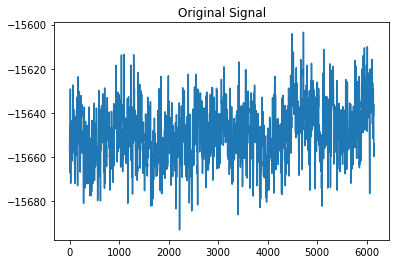

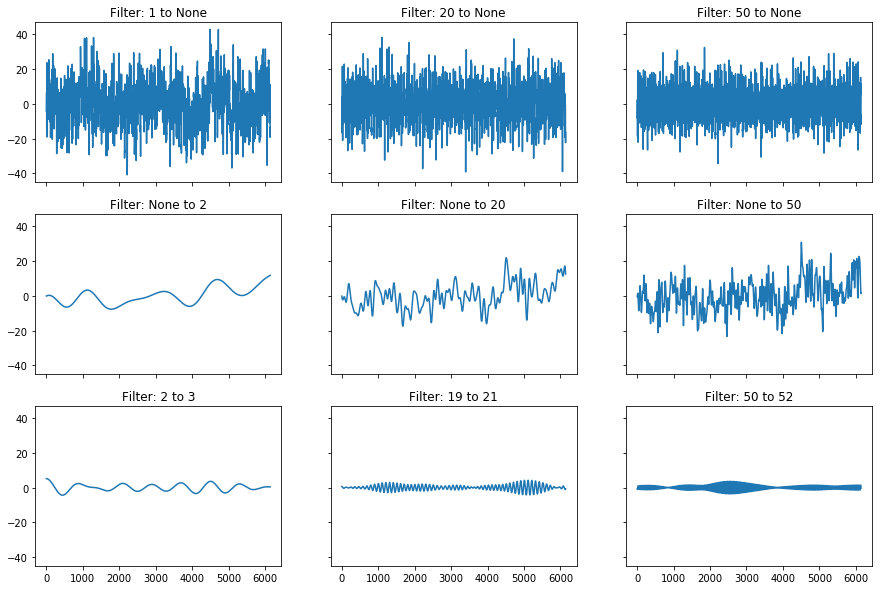

In [107]:
# Different kinds of filters produce different results:
raw_filt = mne.io.Raw(path_data, preload=True).crop(0, 20)

# These are filters we'll use on the data
filters = [(1, None), (20, None), (50, None),
           (None, 2), (None, 20), (None, 50),
           (2, 3), (19, 21), (50, 52)]

# Plot our original signal
fig, ax = plt.subplots()
tmin, tmax = 2, 5 # min, max time in seconds
ax.plot(raw_filt.copy().crop(tmin, tmax)._data[ch_plt])
ax.set(title='Original Signal')

# Make a plot for each type of filtering
fig, axs = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
for ax, (fmin, fmax) in zip(axs.ravel(), filters):
    raw_plt = raw_filt.copy()
    raw_plt = raw_plt.filter(fmin, fmax, verbose=False)
    raw_plt = raw_plt.crop(tmin, tmax)
    raw_plt._data = raw_plt._data - raw_plt._data.mean(-1)[:, np.newaxis]

    ax.plot(raw_plt._data[ch_plt])
    ax.set(title='Filter: {} to {}'.format(fmin, fmax))

In [109]:
# Define a general function to load data, as we did with fMRI
def load_eeg_data(fname, ref_electrode_idx=(6,23), verbose=False,
                  filter_cutoffs=(1,12), return_mne=True):
    """Load EEG data"""
    raw = mne.io.Raw(fname, preload=True)
    # Remove mastoid channels
    raw._data = raw._data[:-2]
    # Reference signal to temporal lobe electrodes
    if ref_electrode_idx is not None:
        ref_electrodes = raw._data[list(ref_electrode_idx)]
        raw._data -= ref_electrodes.mean(0)
    # Smooth the data
    if filter_cutoffs is not None:
        fmin, fmax = filter_cutoffs # Set cutoffs for low and high frequency in data
        raw._data = mne.filter.filter_data(raw._data, raw.info['sfreq'], fmin, fmax, verbose=verbose)
    if return_mne:
        return raw
    else:
        return raw.times, raw._data

In [110]:
subject, session, run = 8, 1, 0
fdir = os.path.join(neurods.io.data_list['eeg'], 'subject{}/session{}/'.format(subject, session))
files = sorted(glob(os.path.join(fdir, '*fif')))
fname = files[run]
times, data = load_eeg_data(fname, return_mne=False)
print(data.shape)

Opening raw data file /data/shared/cogneuro88/eeg/subject8/session1/eeg-raw.fif...
Isotrak not found
    Range : 0 ... 125336 =      0.000 ...    61.199 secs
Ready.
add_eeg_ref defaults to True in 0.13, will default to False in 0.14, and will be removed in 0.15. We recommend to use add_eeg_ref=False and set_eeg_reference() instead.
Adding average EEG reference projection.
1 projection items deactivated
Reading 0 ... 125336  =      0.000 ...    61.199 secs...
(32, 125337)


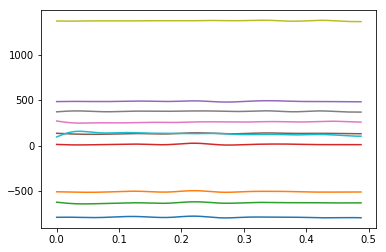

In [111]:
_ = plt.plot(times[:1000], data[:10,:1000].T)

## Plotting sensor locations
Now that we've learned a little bit about the activity itself, there's one more thing we need to know: where these channels are located.

Patterns of recorded neural activity wouldn't be very useful without knowing where that activity was generated. In EEG our sensors sit on the scalp of a person's head. The activity we've been plotting represents electrical activity occurring inside their brains, that makes its way through their skull and ultimately onto their scalp.

MNE has simple functions for plotting the location of sensors with EEG. We can see this below:

In [112]:
%matplotlib inline

In [113]:
# A Montage represents the location of each electrode on the scale
mon = mne.channels.read_montage('standard_1005', raw.ch_names)
raw.set_montage(mon)

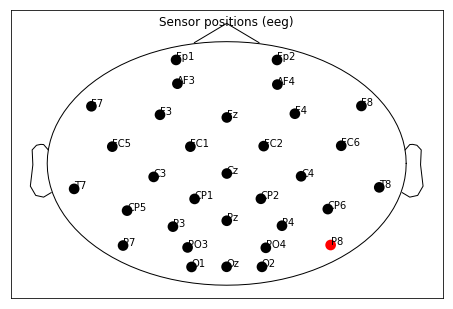

In [114]:
# We can look at the layout of channels on the brain.
# Almost all EEG setups have the same general structure.
_ = raw.plot_sensors(show_names=True)

In [117]:
%matplotlib notebook

<IPython.core.display.Javascript object>


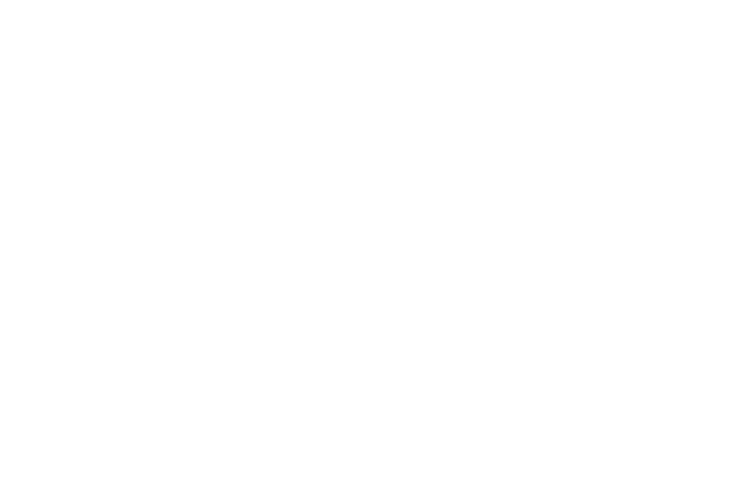

<IPython.core.display.Javascript object>


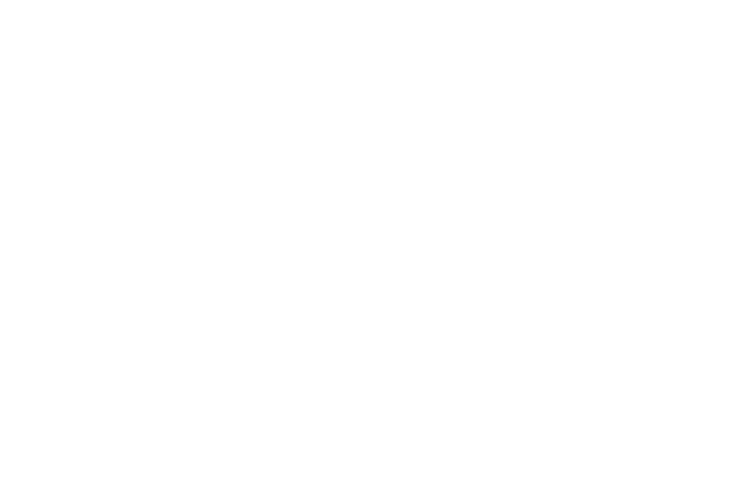

In [120]:
# We can also plot in 3d
fig = raw.plot_sensors('3d')

In [ ]:
fig

### Question
* How given the electrode location plots above, how do you think neuroscientists made this movie:

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('xmf3YC8jzWc')

# Simple event slicing
The last thing we'll look at is how to represent event information. Knowing about brain activity isn't very useful unless you also knew what was happening in the world. For this reason, neuroscientists often record events that correspond to a particular kind of stimulus being shown to a person.

Below we'll show a simple way of representing events in python:

In [126]:
%matplotlib inline
events = mne.read_events(path_events)
events[:10]

array([[ 819,    0,    1],
       [1638,    0,    4],
       [2460,    0,    5],
       [3279,    0,    2],
       [4100,    0,    3],
       [4919,    0,    6],
       [5741,    0,    3],
       [6562,    0,    6],
       [7381,    0,    5],
       [8202,    0,    2]], dtype=uint32)

### Breakout session
* Use matplotlib to plot the first and the third column of the array above. Plot the first 100 samples.
* Now try the same thing, but for histograms (hint, use at least 20 bins in the histogram).
* What do you think each of these two columns represents?

In [ ]:
### STUDENT ANSWER


We can also use MNE to plot the event array itself. This makes it very easy to see what is going on...

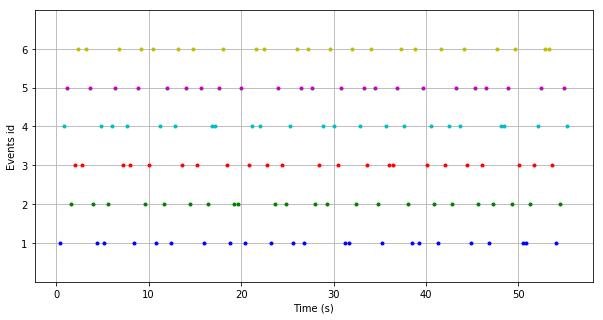

In [127]:
fig, ax = plt.subplots(figsize=(10, 5))
_ = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], axes=ax)

Let's visualize our EEG data along with these events

In [1]:
%matplotlib inline
_ = raw.plot(events=events, scalings='auto')

NameError: name 'raw' is not defined

# Wrapup part 1
In this lecture we covered a couple of basic topics:
* How to visualize the raw data
* How to manipulate the raw data to highlight particular features of the data
* How to show where each channel lies on the brain
* How to note the time onsets of events in our data

These are all the basic tools that we need in order to start figuring out what the brain is doing in response to experiments that we run. The next section will cover one such application.

# Computing event related averages in EEG
Last lecture (and for homework), we computed event-related averages of fMRI data. To do this, we selected all data points after a set of event onset indices. Here, we will do the same with EEG data.

In [129]:
mdata = load_eeg_data(fname, return_mne=True)

Opening raw data file /data/shared/cogneuro88/eeg/subject8/session1/eeg-raw.fif...
Isotrak not found
    Range : 0 ... 125336 =      0.000 ...    61.199 secs
Ready.
add_eeg_ref defaults to True in 0.13, will default to False in 0.14, and will be removed in 0.15. We recommend to use add_eeg_ref=False and set_eeg_reference() instead.
Adding average EEG reference projection.
1 projection items deactivated
Reading 0 ... 125336  =      0.000 ...    61.199 secs...


In [131]:
events[:10]

array([[ 819,    0,    1],
       [1638,    0,    4],
       [2460,    0,    5],
       [3279,    0,    2],
       [4100,    0,    3],
       [4919,    0,    6],
       [5741,    0,    3],
       [6562,    0,    6],
       [7381,    0,    5],
       [8202,    0,    2]], dtype=uint32)

In [132]:
# Select the onsets of a particular condition using a logical index
cond_1 = events[:,2]==1
onset_indices = events[cond_1,0]
print(onset_indices)

[   819   9021  10662  17226  22149  25430  32813  38556  41837  47579
  52503  54964  63988  64809  72192  78754  80394  84496  91881  95982
 103367 104186 110750]


# Breakout session
> Modify the following cell to select the ***time*** period from 0.1 seconds BEFORE the event onset to 0.6 seconds AFTER the event onset

In [133]:
# 
epochs = []
duration = 10 # This value is wrong, even for the code as written! What should this be? 
              # How should you modify the code to select a duration in time?
for o in onset_indices:
    data_slice = mdata._data[:, o:(o+duration)]
    # This if loop is here due to a small problem with the data... 
    if np.any(data_slice):
        epochs.append(data_slice)
epochs = np.array(epochs)
print(epochs.shape)

(23, 32, 10)


In [ ]:
# (repeats per condition, electrodes, time (samples))

In [ ]:
### STUDENT ANSWER


In [ ]:
epochs.mean(0).shape

In [ ]:
from scipy.stats import zscore

In [ ]:
# Compute the mean of the resulting data!
epochs_z = zscore(epochs, axis=-1)
event_avg = epochs_z.mean(0)
etimes = np.linspace(-.1, 0.6, epochs.shape[-1])
_ = plt.plot(etimes, event_avg.T)

Instead of zscoring each entire timecourse, it is common to use the response just BEFORE the event as a baseline. 

In [ ]:
tmin, tmax = -0.1, 0.6
times = np.linspace(tmin, tmax, num=epochs.shape[-1])

# Baseline by pre-stimulus times
baseline_type = 'zscore'  # 'zscore' , 'mean'
epochs_rescaled = mne.baseline.rescale(epochs, times, (None, 0), baseline_type, verbose=False)
